[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import requests

from multiprocessing import Pool
import os
import shutil

from collections.abc import Iterable
import building_utils as U

from PIL import Image
from matplotlib import pyplot as plt, rcParams
import seaborn as sns
from tqdm import tqdm

rcParams['figure.figsize'] = (6, 3)
sns.set_style("ticks", {'axes.grid': True})
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# Группа регионов для анализа (Западная Сибирь)
region_zs = {55: 'Омская область', 70: 'Томская область', 72: 'Тюменская область',
             89: 'Ямало-Ненецкий автономный округ', 86: 'Ханты-Мансийский автономный округ',
             54: 'Новосибирская область', 42: 'Кемеровская область', 22: 'Алтайский край'}

# Загрузка и конвертация данных

In [3]:
class BuildingsLoader:
    def count(self, status: U.BStatus):
        return U.buildings_count(status)

    def load_brief(
        self,
        status: U.BStatus = U.BStatus.CONSTRUCT,
        page_size: int = 500,
        n_jobs: int = 4
    ) -> pd.DataFrame | None:
        count = self.count(status)
        offsets = range(0, count, page_size)
        params = [U.ReadBuildingsParams(offset, page_size, status) for offset in offsets]
        with Pool(n_jobs) as pool:
            res = list(tqdm(
                pool.imap(U.read_buildings_brief, params), 
                total=len(offsets)))
            if len(res) == 0: return None
            res = [v for sub in res for v in sub]
            if len(res) == 0: return None
            return pd.json_normalize(res, sep='_')
    
    def load_full(
        self, 
        obj_ids: list[int], 
        table: bool = True, 
        n_jobs: int = 4
    ) -> pd.DataFrame | None:
        with Pool(n_jobs) as pool:
            res = list(tqdm(
                pool.imap(U.read_building_full, obj_ids), 
                total=len(obj_ids)))
            if len(res) == 0: return None
            return pd.json_normalize(res, sep='_') if table else res


build_loader = BuildingsLoader()

In [8]:
for status in U.BStatus:
    print(f'Buildings in status {status.name}: {build_loader.count(status)}')

Buildings in status CONSTRUCT: 10793
Buildings in status PROBLEM: 1451
Buildings in status COMPLETE: 21142


### 1. Краткая информация об объектах

In [9]:
brief = build_loader.load_brief()
print('Table shape:', brief.shape)
brief.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:38<00:00,  1.74s/it]


Table shape: (10906, 36)


,hobjId,objId,rpdRegionCd,objAddr,objFloorMin,objFloorMax,objElemLivingCnt,objReady100PercDt,objSquareLiving,objCompensFundFlg,objProblemFlg,latitude,longitude,problemFlag,siteStatus,objGuarantyEscrowFlg,residentialBuildings,rpdNum,pdId,buildType,objStatus,developer_devId,developer_shortName,developer_fullName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_devInn,objCommercNm,developer_groupName,developer_companyGroup,complexShortName,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm
0,25138,831,73,"г Ульяновск, транспортная, д. 68",6,8,50,2023-12-31,3103.00,0,0,54.2942,48.3632,NONE,Строящиеся,1,1,73-000193,1332,Жилое,0,12763,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФЗПГ,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФОНД ЗАЩИТЫ ПРАВ ГРАЖДАН...,91,Фонд,Фонд,7325167407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34204,1259,62,"г Рязань, улица Бугровка, д. 0",27,27,440,2023-12-31,24051.13,0,0,54.6045,39.8214,NONE,Строящиеся,1,1,62-000075,1320,Жилое,0,773,КРИСТАЛЛ,КРИСТАЛЛ,4,Общество с ограниченной ответственностью,ООО,6215031345,"""СМАРТ дом на Новоселов""",Капитал,5610.0,NaN,NaN,NaN,NaN,NaN
2,13061,1284,77,"г Москва, район внутригородское муниципальное ...",27,27,1115,2024-12-31,45733.40,0,0,55.8608,37.3755,NONE,Строящиеся,1,1,77-000508,1527,Жилое,0,175,РОЖДЕСТВЕНО,РОЖДЕСТВЕНО,4,Общество с ограниченной ответственностью,ООО,7701579283,"Жилой Комплекс ""Мир Митино"" (сокращенное наиме...",Рождествено,8651.0,Мир Митино,NaN,NaN,NaN,NaN


In [10]:
# странное поведение api: фильтр из параметров запроса работает криво, т.к. запрашиваются только со статусом 0
brief.objStatus.value_counts()

0    10894
2       12
Name: objStatus, dtype: int64

In [15]:
# еще одна странность api: в результатах постраничного запроса появляются дубликаты (замена поля сотрировки не решает проблему)
brief.duplicated('objId').sum()

322

### 2. Полная информация об объектах

In [12]:
# грузить будем выборочно для какой-нибудь группы регионов (выбрал Западную Сибирь), 
# т.к. сервер плохо реагирует на массовые запросы
obj_ids_zs = brief[brief.rpdRegionCd.isin(region_zs.keys())].objId
full_zs = build_loader.load_full(obj_ids_zs, 8)
print('Table shape:', full_zs.shape)
full_zs.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1238/1238 [02:26<00:00,  8.47it/s]

Table shape: (1238, 110)


,id,hobjId,pdId,region,address,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,rpdNum,rpdPdfLink,rpdIssueDttm,objLkLatitude,objLkLongitude,objCompensFundFlg,objProblemFlg,objLkClassDesc,loadDttm,photoRenderDTO,objGuarantyEscrowFlg,objectType,miniUrl,residentialBuildings,newBuildingId,objFloorCnt,objFlatCnt,objFlatSq,objNonlivElemCnt,objStatus,isAvailableWantLiveHere,objTransferPlanDt,objLivCeilingHeight,objInfrstrBicycleLaneFlg,objInfrstrPlaygrndCnt,objInfrstrSportGroundCnt,objInfrstrTrashAreaCnt,objInfrstrObjPrkngCnt,objInfrstrNotObjPrkngCnt,objInfrstrRampFlg,objInfrstrCurbLoweringFlg,objElevatorWheelchairCnt,objElevatorPassengerCnt,objElevatorCargoCnt,objElevatorCargoPassengerCnt,soldOutPerc,...,developer_devShortCleanNm,developer_devShortNm,developer_devFullCleanNm,developer_problObjCnt,developer_buildObjCnt,developer_comissObjCnt,developer_regRegionDesc,developer_devPhoneNum,developer_devSite,developer_devEmail,developer_devInn,developer_devOgrn,developer_devKpp,developer_devLegalAddr,developer_devFactAddr,developer_lastRpdId,developer_fundGuarantyFlg,developer_devOrgRegRegionCd,developer_devEmplMainFullNm,developer_developerGroupName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_companyGroupId,developer_objGuarantyEscrowFlg,developer_govFundFlg,quartography_objLivElem1KCnt,quartography_objLivElem2KCnt,quartography_objLivElem3KCnt,quartography_objLivElem4KCnt,quartography_objLivElemCnt,quartography_objLivElemEntrCnt,quartography_objLivElemEntrFloorAvg,nameObj,transportDistIndex,transportDistIndexValue,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm,metro_id,metro_name,metro_line,metro_color,metro_time,metro_isWalk,metro_colors,complexShortNm,rnvFlg,rnvDTO
0,1527,9709,2281,42,"г Мыски, улица Горького, д. 7",9,9,70,2023-12-31,Блоки,Под ключ,Нет,0,3408.20,42-000003,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,06-12-2022 07:09,53.7136,87.8051,1,0,Типовой,14-12-2022 01:24,"[{'objId': 1527, 'pdId': 2281, 'rpdId': 663681...",0,normal,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,1,9709.0,9,70,3408.2,2,0,True,31-01-2024 12:00,"2,64",0,1.0,2.0,1.0,19.0,0.0,1,0,0.0,2.0,0.0,0,0.839646,...,ИСК,ИСК,ИНВЕСТИЦИОННО-СТРОИТЕЛЬНАЯ КОМПАНИЯ,0,1,0,Кемеровская область - Кузбасс,+7(906)986-81-62,isksib.ru,ms.isk2013@mail.ru,4253014114,1134253002685,425301001,"Кемеровская область - Кузбасс, г Мыски, улица ...","обл Кемеровская область - Кузбасс, г Мыски, ул...",663681,1,42.0,Измаилов Вадим Равилович,Инвестиционно-стоительная компания,4,Общество с ограниченной ответственностью,ООО,7010.0,0,0,34.0,34.0,2.0,0.0,70.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3326,11501,6264,54,"с/с Мичуринский, улица Есенина, д. 29",5,5,60,2023-06-30,Монолит-кирпич,Без отделки,Нет,0,2908.60,54-000032,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,31-10-2022 10:49,54.9253,82.9439,1,0,Типовой,14-12-2022 01:24,"[{'objId': 3326, 'pdId': 6264, 'rpdId': 650876...",0,normal,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,1,11501.0,5,60,2908.6,21,0,True,31-07-2023 12:00,"2,7",1,1.0,1.0,1.0,5.0,5.0,1,1,0.0,0.0,0.0,0,0.423228,...,ПРОМТЕХЦЕНТР,ПРОМТЕХЦЕНТР,ПРОМТЕХЦЕНТР,0,1,0,Новосибирская область,+7(913)915-68-17,жк-элитный.рф,ptc3733215@yandex.ru,5403199645,1075403010660,540401001,"Новосибирская область, г Новосибирск, мкр Горс...","обл Новосибирская область, г Новосибирск, мкр ...",650876,1,54.0,Шикин Валерий Юрьевич,ПромТехЦентр,4,Общество с ограниченной ответственностью,ООО,8257.0,0,0,30.0,30.0,0.0,0.0,60.0,3.0,4.0,"Жилой комплекс ""Элитный""",3 / 10,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4409,758,8593,54,"рп Кольцово, улица Микрорайон IX, д. 7",5,5,64,2022-12-31,Кирпич,Под чистовую,Нет,0,4702.47,54-000059,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,05-12-2022

In [16]:
# пример с отсутствующей фотографией
build_loader.load_full([38115], table=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


[{'id': 38115,
  'hobjId': 118519,
  'pdId': 404281,
  'developer': {'devId': 11215,
   'devShortCleanNm': 'СЗ ЖК ЭНТУЗИАСТ',
   'devShortNm': 'СЗ ЖК ЭНТУЗИАСТ',
   'devFullCleanNm': 'СПЕЦИАЛИЗИРОВАННЫЙЗАСТРОЙЩИК ЖК ЭНТУЗИАСТ',
   'problObjCnt': 0,
   'buildObjCnt': 1,
   'comissObjCnt': 0,
   'regRegionDesc': 'Приморский край',
   'devPhoneNum': '+7(423)664-00-00',
   'devSite': 'www.mjk-stroi.ru',
   'devEmail': 'zhk.entuziast@mail.ru',
   'devInn': '2508138475',
   'devOgrn': '1202500019567',
   'devKpp': '250801001',
   'devLegalAddr': 'Приморский край, город Находка, бульвар Энтузиастов дом 15 офис 312',
   'devFactAddr': 'Приморский край, город Находка, Бульвар Энтузиастов, Дом 15, Офис 312',
   'lastRpdId': 661971,
   'fundGuarantyFlg': 0,
   'devOrgRegRegionCd': 25,
   'devEmplMainFullNm': 'Ходырев Александр Михайлович',
   'orgForm': {'id': 4,
    'fullForm': 'Общество с ограниченной ответственностью',
    'shortForm': 'ООО'},
   'objGuarantyEscrowFlg': 1,
   'govFundFlg': 0},

# Сохранение/чтение таблиц

In [17]:
class Saver:
    def save_csv(self, data: pd.DataFrame, filepath: str):
        data.to_csv(filepath, index=False)

    def save_pickle(self, data: pd.DataFrame, filepath: str):
        data.to_pickle(filepath)

    def save_excel(self, data: pd.DataFrame, filepath: str, sheet_name: str = 'data'):
        data.to_excel(filepath, index=False, sheet_name=sheet_name)

    def save_sql(self, data: pd.DataFrame, dbpath: str, table: str):
        with sql.connect(dbpath) as con:
            data.to_sql(table, con, if_exists='replace', index=False)


class Reader:
    def read_csv(self, filepath: str) -> pd.DataFrame:
        return pd.read_csv(filepath)

    def read_pickle(self, filepath: str) -> pd.DataFrame:
        return pd.read_pickle(filepath)
    
    def read_excel(self, filepath: str) -> pd.DataFrame:
        return pd.read_excel(filepath)

    def read_sql(self, dbpath: str, table: str):
        with sql.connect(dbpath) as con:
            return pd.read_sql(f'select * from {table}', con)


saver = Saver()
reader = Reader()

### 1. save/read csv

In [18]:
saver.save_csv(brief, 'brief.csv')

In [19]:
reader.read_csv('brief.csv').head(3)

,hobjId,objId,rpdRegionCd,objAddr,objFloorMin,objFloorMax,objElemLivingCnt,objReady100PercDt,objSquareLiving,objCompensFundFlg,objProblemFlg,latitude,longitude,problemFlag,siteStatus,objGuarantyEscrowFlg,residentialBuildings,rpdNum,pdId,buildType,objStatus,developer_devId,developer_shortName,developer_fullName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_devInn,objCommercNm,developer_groupName,developer_companyGroup,complexShortName,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm
0,25138,831,73,"г Ульяновск, транспортная, д. 68",6,8,50,2023-12-31,3103.00,0,0,54.2942,48.3632,NONE,Строящиеся,1,1,73-000193,1332,Жилое,0,12763,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФЗПГ,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФОНД ЗАЩИТЫ ПРАВ ГРАЖДАН...,91,Фонд,Фонд,7325167407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34204,1259,62,"г Рязань, улица Бугровка, д. 0",27,27,440,2023-12-31,24051.13,0,0,54.6045,39.8214,NONE,Строящиеся,1,1,62-000075,1320,Жилое,0,773,КРИСТАЛЛ,КРИСТАЛЛ,4,Общество с ограниченной ответственностью,ООО,6215031345,"""СМАРТ дом на Новоселов""",Капитал,5610.0,NaN,NaN,NaN,NaN,NaN
2,13061,1284,77,"г Москва, район внутригородское муниципальное ...",27,27,1115,2024-12-31,45733.40,0,0,55.8608,37.3755,NONE,Строящиеся,1,1,77-000508,1527,Жилое,0,175,РОЖДЕСТВЕНО,РОЖДЕСТВЕНО,4,Общество с ограниченной ответственностью,ООО,7701579283,"Жилой Комплекс ""Мир Митино"" (сокращенное наиме...",Рождествено,8651.0,Мир Митино,NaN,NaN,NaN,NaN


### 2. save/read pickle

In [20]:
saver.save_pickle(brief, 'brief.pkl')

In [21]:
reader.read_pickle('brief.pkl').head(3)

,hobjId,objId,rpdRegionCd,objAddr,objFloorMin,objFloorMax,objElemLivingCnt,objReady100PercDt,objSquareLiving,objCompensFundFlg,objProblemFlg,latitude,longitude,problemFlag,siteStatus,objGuarantyEscrowFlg,residentialBuildings,rpdNum,pdId,buildType,objStatus,developer_devId,developer_shortName,developer_fullName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_devInn,objCommercNm,developer_groupName,developer_companyGroup,complexShortName,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm
0,25138,831,73,"г Ульяновск, транспортная, д. 68",6,8,50,2023-12-31,3103.00,0,0,54.2942,48.3632,NONE,Строящиеся,1,1,73-000193,1332,Жилое,0,12763,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФЗПГ,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФОНД ЗАЩИТЫ ПРАВ ГРАЖДАН...,91,Фонд,Фонд,7325167407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34204,1259,62,"г Рязань, улица Бугровка, д. 0",27,27,440,2023-12-31,24051.13,0,0,54.6045,39.8214,NONE,Строящиеся,1,1,62-000075,1320,Жилое,0,773,КРИСТАЛЛ,КРИСТАЛЛ,4,Общество с ограниченной ответственностью,ООО,6215031345,"""СМАРТ дом на Новоселов""",Капитал,5610.0,NaN,NaN,NaN,NaN,NaN
2,13061,1284,77,"г Москва, район внутригородское муниципальное ...",27,27,1115,2024-12-31,45733.40,0,0,55.8608,37.3755,NONE,Строящиеся,1,1,77-000508,1527,Жилое,0,175,РОЖДЕСТВЕНО,РОЖДЕСТВЕНО,4,Общество с ограниченной ответственностью,ООО,7701579283,"Жилой Комплекс ""Мир Митино"" (сокращенное наиме...",Рождествено,8651.0,Мир Митино,NaN,NaN,NaN,NaN


In [22]:
saver.save_pickle(full_zs, 'full_zs.pkl')

In [23]:
reader.read_pickle('full_zs.pkl').head(3)

,id,hobjId,pdId,region,address,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,rpdNum,rpdPdfLink,rpdIssueDttm,objLkLatitude,objLkLongitude,objCompensFundFlg,objProblemFlg,objLkClassDesc,loadDttm,photoRenderDTO,objGuarantyEscrowFlg,objectType,miniUrl,residentialBuildings,newBuildingId,objFloorCnt,objFlatCnt,objFlatSq,objNonlivElemCnt,objStatus,isAvailableWantLiveHere,objTransferPlanDt,objLivCeilingHeight,objInfrstrBicycleLaneFlg,objInfrstrPlaygrndCnt,objInfrstrSportGroundCnt,objInfrstrTrashAreaCnt,objInfrstrObjPrkngCnt,objInfrstrNotObjPrkngCnt,objInfrstrRampFlg,objInfrstrCurbLoweringFlg,objElevatorWheelchairCnt,objElevatorPassengerCnt,objElevatorCargoCnt,objElevatorCargoPassengerCnt,soldOutPerc,...,developer_devShortCleanNm,developer_devShortNm,developer_devFullCleanNm,developer_problObjCnt,developer_buildObjCnt,developer_comissObjCnt,developer_regRegionDesc,developer_devPhoneNum,developer_devSite,developer_devEmail,developer_devInn,developer_devOgrn,developer_devKpp,developer_devLegalAddr,developer_devFactAddr,developer_lastRpdId,developer_fundGuarantyFlg,developer_devOrgRegRegionCd,developer_devEmplMainFullNm,developer_developerGroupName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_companyGroupId,developer_objGuarantyEscrowFlg,developer_govFundFlg,quartography_objLivElem1KCnt,quartography_objLivElem2KCnt,quartography_objLivElem3KCnt,quartography_objLivElem4KCnt,quartography_objLivElemCnt,quartography_objLivElemEntrCnt,quartography_objLivElemEntrFloorAvg,nameObj,transportDistIndex,transportDistIndexValue,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm,metro_id,metro_name,metro_line,metro_color,metro_time,metro_isWalk,metro_colors,complexShortNm,rnvFlg,rnvDTO
0,1527,9709,2281,42,"г Мыски, улица Горького, д. 7",9,9,70,2023-12-31,Блоки,Под ключ,Нет,0,3408.20,42-000003,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,06-12-2022 07:09,53.7136,87.8051,1,0,Типовой,14-12-2022 01:24,"[{'objId': 1527, 'pdId': 2281, 'rpdId': 663681...",0,normal,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,1,9709.0,9,70,3408.2,2,0,True,31-01-2024 12:00,"2,64",0,1.0,2.0,1.0,19.0,0.0,1,0,0.0,2.0,0.0,0,0.839646,...,ИСК,ИСК,ИНВЕСТИЦИОННО-СТРОИТЕЛЬНАЯ КОМПАНИЯ,0,1,0,Кемеровская область - Кузбасс,+7(906)986-81-62,isksib.ru,ms.isk2013@mail.ru,4253014114,1134253002685,425301001,"Кемеровская область - Кузбасс, г Мыски, улица ...","обл Кемеровская область - Кузбасс, г Мыски, ул...",663681,1,42.0,Измаилов Вадим Равилович,Инвестиционно-стоительная компания,4,Общество с ограниченной ответственностью,ООО,7010.0,0,0,34.0,34.0,2.0,0.0,70.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3326,11501,6264,54,"с/с Мичуринский, улица Есенина, д. 29",5,5,60,2023-06-30,Монолит-кирпич,Без отделки,Нет,0,2908.60,54-000032,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,31-10-2022 10:49,54.9253,82.9439,1,0,Типовой,14-12-2022 01:24,"[{'objId': 3326, 'pdId': 6264, 'rpdId': 650876...",0,normal,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,1,11501.0,5,60,2908.6,21,0,True,31-07-2023 12:00,"2,7",1,1.0,1.0,1.0,5.0,5.0,1,1,0.0,0.0,0.0,0,0.423228,...,ПРОМТЕХЦЕНТР,ПРОМТЕХЦЕНТР,ПРОМТЕХЦЕНТР,0,1,0,Новосибирская область,+7(913)915-68-17,жк-элитный.рф,ptc3733215@yandex.ru,5403199645,1075403010660,540401001,"Новосибирская область, г Новосибирск, мкр Горс...","обл Новосибирская область, г Новосибирск, мкр ...",650876,1,54.0,Шикин Валерий Юрьевич,ПромТехЦентр,4,Общество с ограниченной ответственностью,ООО,8257.0,0,0,30.0,30.0,0.0,0.0,60.0,3.0,4.0,"Жилой комплекс ""Элитный""",3 / 10,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4409,758,8593,54,"рп Кольцово, улица Микрорайон IX, д. 7",5,5,64,2022-12-31,Кирпич,Под чистовую,Нет,0,4702.47,54-000059,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,05-12-2022

### 3. save/read xlsx

In [24]:
saver.save_excel(brief, 'brief.xlsx')

In [25]:
reader.read_excel('brief.xlsx').head(3)

,hobjId,objId,rpdRegionCd,objAddr,objFloorMin,objFloorMax,objElemLivingCnt,objReady100PercDt,objSquareLiving,objCompensFundFlg,objProblemFlg,latitude,longitude,problemFlag,siteStatus,objGuarantyEscrowFlg,residentialBuildings,rpdNum,pdId,buildType,objStatus,developer_devId,developer_shortName,developer_fullName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_devInn,objCommercNm,developer_groupName,developer_companyGroup,complexShortName,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm
0,25138,831,73,"г Ульяновск, транспортная, д. 68",6,8,50,2023-12-31,3103.00,0,0,54.2942,48.3632,NONE,Строящиеся,1,1,73-000193,1332,Жилое,0,12763,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФЗПГ,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФОНД ЗАЩИТЫ ПРАВ ГРАЖДАН...,91,Фонд,Фонд,7325167407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34204,1259,62,"г Рязань, улица Бугровка, д. 0",27,27,440,2023-12-31,24051.13,0,0,54.6045,39.8214,NONE,Строящиеся,1,1,62-000075,1320,Жилое,0,773,КРИСТАЛЛ,КРИСТАЛЛ,4,Общество с ограниченной ответственностью,ООО,6215031345,"""СМАРТ дом на Новоселов""",Капитал,5610.0,NaN,NaN,NaN,NaN,NaN
2,13061,1284,77,"г Москва, район внутригородское муниципальное ...",27,27,1115,2024-12-31,45733.40,0,0,55.8608,37.3755,NONE,Строящиеся,1,1,77-000508,1527,Жилое,0,175,РОЖДЕСТВЕНО,РОЖДЕСТВЕНО,4,Общество с ограниченной ответственностью,ООО,7701579283,"Жилой Комплекс ""Мир Митино"" (сокращенное наиме...",Рождествено,8651.0,Мир Митино,NaN,NaN,NaN,NaN


### 4. save/read sql

In [26]:
saver.save_sql(brief, 'brief.db', 'brief')

In [27]:
reader.read_sql('brief.db', 'brief').head(3)

,hobjId,objId,rpdRegionCd,objAddr,objFloorMin,objFloorMax,objElemLivingCnt,objReady100PercDt,objSquareLiving,objCompensFundFlg,objProblemFlg,latitude,longitude,problemFlag,siteStatus,objGuarantyEscrowFlg,residentialBuildings,rpdNum,pdId,buildType,objStatus,developer_devId,developer_shortName,developer_fullName,developer_orgForm_id,developer_orgForm_fullForm,developer_orgForm_shortForm,developer_devInn,objCommercNm,developer_groupName,developer_companyGroup,complexShortName,developer_bankruptStage_bankruptStageCd,developer_bankruptStage_bankruptStageDesc,developer_bankruptStage_bankruptLawUrl,developer_orgBankruptMsgDttm
0,25138,831,73,"г Ульяновск, транспортная, д. 68",6,8,50,2023-12-31,3103.00,0,0,54.2942,48.3632,NONE,Строящиеся,1,1,73-000193,1332,Жилое,0,12763,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФЗПГ,УЛЬЯНОВСКИЙ ОБЛАСТНОЙ ФОНД ЗАЩИТЫ ПРАВ ГРАЖДАН...,91,Фонд,Фонд,7325167407,None,None,NaN,None,NaN,None,None,None
1,34204,1259,62,"г Рязань, улица Бугровка, д. 0",27,27,440,2023-12-31,24051.13,0,0,54.6045,39.8214,NONE,Строящиеся,1,1,62-000075,1320,Жилое,0,773,КРИСТАЛЛ,КРИСТАЛЛ,4,Общество с ограниченной ответственностью,ООО,6215031345,"""СМАРТ дом на Новоселов""",Капитал,5610.0,None,NaN,None,None,None
2,13061,1284,77,"г Москва, район внутригородское муниципальное ...",27,27,1115,2024-12-31,45733.40,0,0,55.8608,37.3755,NONE,Строящиеся,1,1,77-000508,1527,Жилое,0,175,РОЖДЕСТВЕНО,РОЖДЕСТВЕНО,4,Общество с ограниченной ответственностью,ООО,7701579283,"Жилой Комплекс ""Мир Митино"" (сокращенное наиме...",Рождествено,8651.0,Мир Митино,NaN,None,None,None


# Сохранение/вывод фото объектов

In [28]:
class PhotoLoader:
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
    
    def load_photos(self, obj_ids: Iterable, n_jobs: int = 4):
        shutil.rmtree(self.root_dir, ignore_errors=True)
        os.makedirs(self.root_dir)
        with Pool(n_jobs) as pool:
            params = []
            for obj_id in obj_ids:
                dir_name = os.path.join(self.root_dir, str(obj_id))
                os.makedirs(dir_name)
                params.append(U.SavePhotosParams(obj_id, dir_name))
            list(tqdm(
                pool.imap_unordered(U.save_building_photos, params),
                total=len(obj_ids)))

    def show_random_photos(self, count: tuple[int, int]):
        count_flat = count[0] * count[1]
        all_files = []
        for root, _, files in os.walk(self.root_dir):
            all_files.extend([f'{root}/{fname}' for fname in files])
        photos = np.random.choice(all_files, count_flat, replace=False)

        _, ax = plt.subplots(*count, figsize=tuple(v * 5 for v in count))
        ax = ax.flatten()
        for i in range(count_flat):
            image = Image.open(photos[i])
            ax[i].set(title=photos[i])
            ax[i].imshow(image)
            ax[i].set_axis_off()

In [29]:
photo_loader = PhotoLoader('./photos')

In [30]:
obj_ids = full_zs.id.sample(10)
photo_loader.load_photos(obj_ids)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


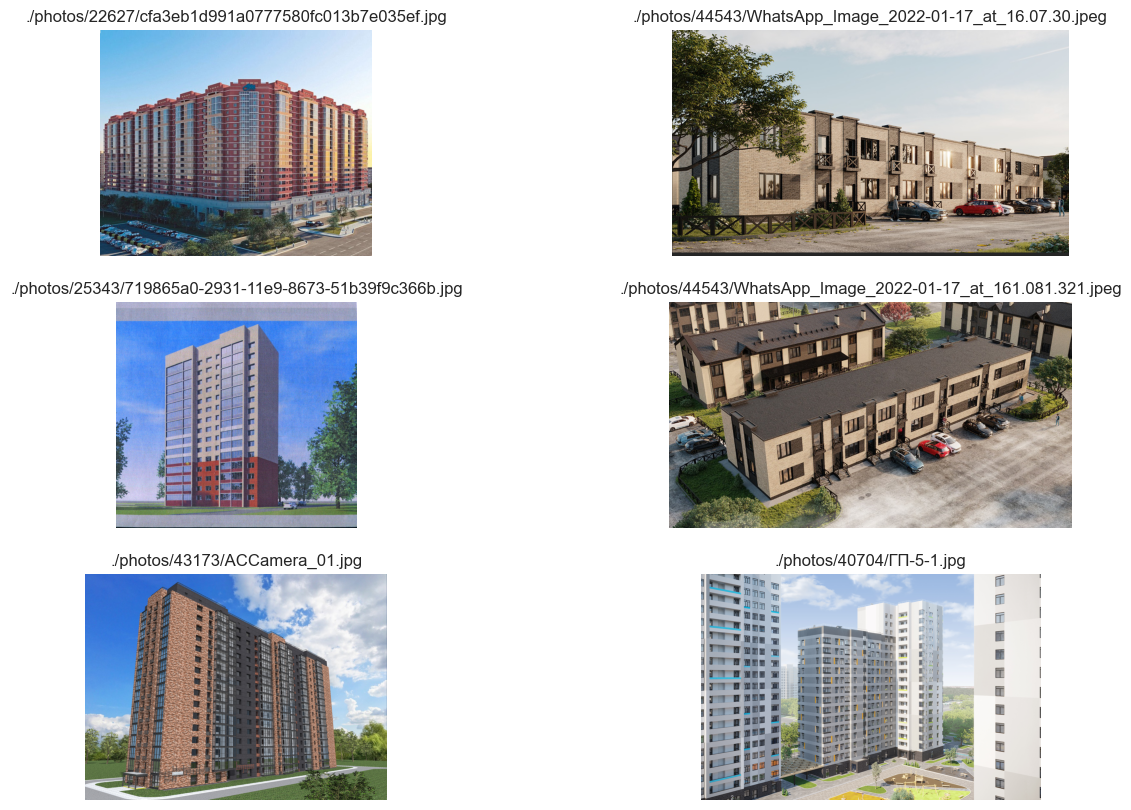

In [33]:
photo_loader.show_random_photos((3, 2))

# Анализ и визуализация

Описание используемых колонок в используемых таблицах `brief` и `full`:
* id объекта: `brief['objId']`, `full['id']`
* цена за кв. метр: `full['objPriceAvg']`
* код региона: `brief['rpdRegionCd']`, `full['region']`
* дата ввода в эксплуатацию: `brief['objReady100PercDt']`, `full['objReady100PercDt']`
* кол-во этажей: `brief['objFloorMax']`, `full['objFloorCnt']`
* кол-во квартир: `brief['objElemLivingCnt']`, `full['objFlatCnt']`
* общая жилая площадь: `brief['objSquareLiving']`, `full['objFlatSq']`
* кол-во парковочных мест: `full['objElemParkingCnt']`

In [34]:
class DataExtractor:
    def load_data(self, brief_pickle_path: str, full_pickle_path: str) -> pd.DataFrame:
        """
        * отфильтруем только нужные колонки
        * удалим дубликаты
        * оставим только объекты со статусом 0 (Строящиеся)
        * приведем к ожидаемому типу некоторые колонки
        """

        brief = reader.read_pickle(brief_pickle_path)
        brief = brief[brief.objStatus == 0]
        brief = brief[['objId', 'buildType']]
        brief = brief.drop_duplicates('objId')

        full = reader.read_pickle(full_pickle_path)
        full = full[['id', 'objPriceAvg', 'region', 'objReady100PercDt', 
                     'objFloorCnt', 'objFlatCnt', 'objFlatSq', 'objElemParkingCnt']]
        full = full.drop_duplicates('id')
        full['objReady100PercDt'] = pd.to_datetime(full.objReady100PercDt)
        full['objFlatSq'] = full.objFlatSq.astype(float)

        return pd.merge(full, brief, 'inner', left_on='id', right_on='objId').drop(columns='objId')


class Visualizer:
    def __init__(self, data):
        self.data = data
        self.living = data.query('buildType == "Жилое"')
        self.region_names = sorted(region_zs.values())
    
    def __data(self, living_only):
        return self.living if living_only else self.data

    def make_boxplot(self, param, living_only=True):
        plt.figure(figsize=(8, 4))
        plot_data = self.__data(living_only)
        sns.boxplot(
            data=plot_data,
            y='regionName', x=param, orient='h',
            order=self.region_names,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"}
        );

    def make_stats(self, param, living_only=True):
        plot_data = self.__data(living_only)
        return plot_data.groupby('regionName')[param].describe()

    def make_heatmap(self, index, columns, values, aggfunc, living_only=True):
        plot_data = self.__data(living_only)
        rc = plot_data.pivot_table(index=index, columns=columns, values=values, aggfunc=aggfunc)
        plt.figure(figsize=(8, 4))
        sns.heatmap(rc, annot=True, cmap='crest', fmt='.1f');

### Подготовка

In [35]:
extractor = DataExtractor()
data_zs = extractor.load_data('brief.pkl', 'full_zs.pkl')
print(data_zs.shape)
data_zs.head(3)

(1184, 9)


,id,objPriceAvg,region,objReady100PercDt,objFloorCnt,objFlatCnt,objFlatSq,objElemParkingCnt,buildType
0,1527,33550.0,42,2023-12-31,9,70,3408.20,0,Жилое
1,3326,35757.0,54,2023-06-30,5,60,2908.60,0,Жилое
2,4409,95707.0,54,2022-12-31,5,64,4702.47,0,Жилое


In [36]:
data_zs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1183
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1184 non-null   int64         
 1   objPriceAvg        749 non-null    float64       
 2   region             1184 non-null   int64         
 3   objReady100PercDt  1184 non-null   datetime64[ns]
 4   objFloorCnt        1184 non-null   int64         
 5   objFlatCnt         1184 non-null   int64         
 6   objFlatSq          1184 non-null   float64       
 7   objElemParkingCnt  1184 non-null   int64         
 8   buildType          1184 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 92.5+ KB


##### Колонка `цена за кв. метр`

Значения в `objPriceAvg` имеют пропуски. Посмотрим на распределение данных

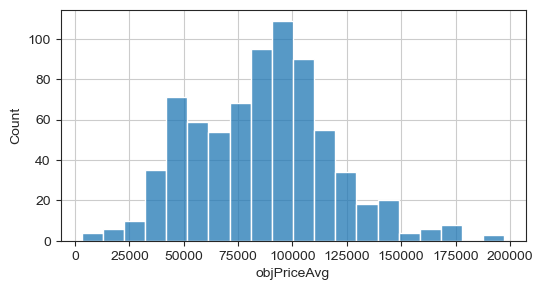

In [37]:
sns.histplot(data=data_zs, x='objPriceAvg', bins=20);

Распределение похоже на нормальное. Попробуем заменить пропуски случайной выборкой из нормального распределения, чтобы не портить исходное распределение

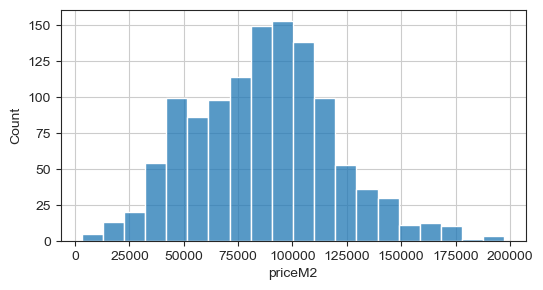

In [38]:
price = data_zs.objPriceAvg
r = np.random.normal(price.mean(), price.std(), len(price))
data_zs['priceM2'] = price.where(price.notna(), r)

sns.histplot(data=data_zs, x='priceM2', bins=20);

##### Колонка `регион`

Коды регионов заменим на названия

In [39]:
data_zs['regionName'] = data_zs.region.map(region_zs)
data_zs.head(3)

,id,objPriceAvg,region,objReady100PercDt,objFloorCnt,objFlatCnt,objFlatSq,objElemParkingCnt,buildType,priceM2,regionName
0,1527,33550.0,42,2023-12-31,9,70,3408.20,0,Жилое,33550.0,Кемеровская область
1,3326,35757.0,54,2023-06-30,5,60,2908.60,0,Жилое,35757.0,Новосибирская область
2,4409,95707.0,54,2022-12-31,5,64,4702.47,0,Жилое,95707.0,Новосибирская область


Остальные колонки не имеют пропусков и не являются категориальными. Пока не будем их трогать

### Анализ

In [40]:
data_zs['commisYear'] = pd.DatetimeIndex(data_zs.objReady100PercDt).year

visualizer = Visualizer(data_zs)

#### Количество строящихся зданий по регионам (любой тип)

In [46]:
data_zs.groupby(['regionName', 'buildType']).buildType.count().to_frame()

buildType
regionName                        buildType           
Алтайский край                    Жилое             69
                                  Нежилое           14
Кемеровская область               Жилое             70
Новосибирская область             Жилое            546
                                  Нежилое           29
Омская область                    Жилое             64
                                  Нежилое            3
Томская область                   Жилое             42
                                  Нежилое            1
Тюменская область                 Жилое            229
                                  Нежилое           19
Ханты-Мансийский автономный округ Жилое             51
                                  Нежилое            5
Ямало-Ненецкий автономный округ   Жилое             40
                                  Нежилое            2

Выводы:
* Видно, что в данных регионах строятся в основном жилые помещения (дальше будем анализировать только жилые помещения)
* Наибольшее количество жилых помещения строится в Новосибирской и Тюменской областях
* Меньше всего жилых домов - в ЯНАО и Томской области (Томск - студенческий город, а где жить студентам?)

#### Средние цены за кв. метр по регионам (только жилые)

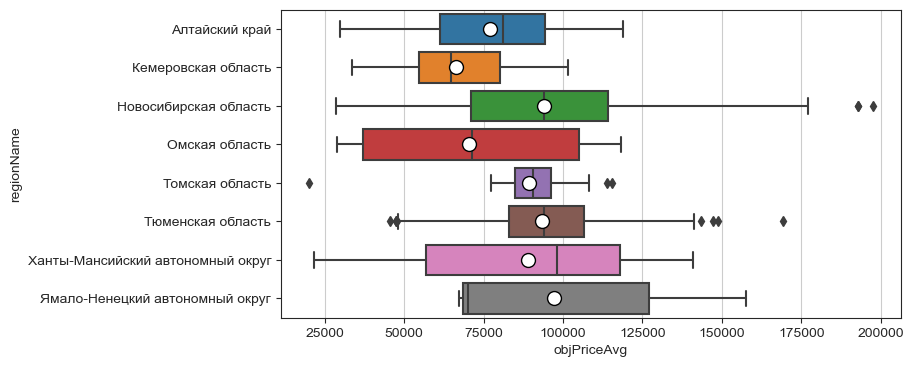

In [48]:
visualizer.make_boxplot('objPriceAvg')

Выводы:
* Самое дешевое жилье (по медиане) в Кемеровской и Омской областях (видимо из-за проблем с экологией), а также в ЯМАО (холодно, однако)
* Самое дорогое (по медиане) - в ХМАО
* белая точка - среднее арифметическое. Как видно почти у всех регионов она совпадает с медианой. Но в ЯМАО это не так: медиана смещена далеко влево от среднего. Это говорит о том, что основная масса жилья продается по нижней границе диапазона цен  

#### Объемы вводимого жилья по регионам и годам (жилое)

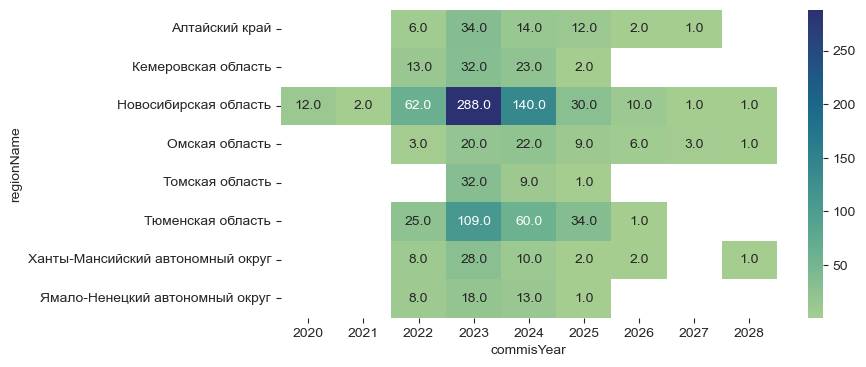

In [49]:
visualizer.make_heatmap('regionName', 'commisYear', 'id', 'count')

Выводы:
* В следующем году в Новосибирской области будет больше всего новоселов
* В 2024 году почти во всех регионах планируется сдать меньше жилых домов чем в 2023
* В ЯНАО, Томской и Кемеровской областях пока не планируют строить новое жилье к 2026-... годам

#### Этажность жилых домов по регионам

,count,mean,std,min,25%,50%,75%,max
regionName,,,,,,,,
Алтайский край,69.0,14.492754,5.120958,5.0,10.0,17.0,18.00,26.0
Кемеровская область,70.0,11.557143,5.586308,2.0,6.5,14.0,16.00,20.0
Новосибирская область,546.0,10.331502,9.352525,1.0,2.0,5.0,18.00,33.0
Омская область,64.0,13.078125,4.636996,6.0,10.0,11.0,17.00,23.0
Томская область,42.0,9.952381,6.980644,2.0,2.0,9.5,17.75,24.0
Тюменская область,229.0,13.358079,7.569166,2.0,5.0,15.0,19.00,32.0
Ханты-Мансийский автономный округ,51.0,11.568627,5.441525,4.0,8.0,10.0,16.00,25.0
Ямало-Ненецкий автономный округ,40.0,6.225000,2.465012,3.0,4.0,6.0,8.00,11.0


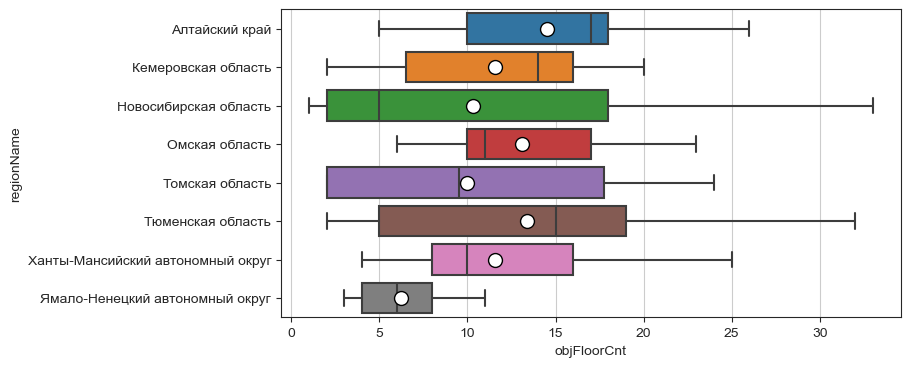

In [50]:
visualizer.make_boxplot('objFloorCnt')
visualizer.make_stats('objFloorCnt')

Выводы:
* Самый высокий дом строят в Новосибирской области, хотя по медиане в этом регионе преобладают 5-этажные дома
* В Алтайском крае этажность по медиане самая большая, т.е. строится много высоток (подтверждаю, сам живу в Барнауле)
* Во всех регионах (кроме ЯНАО) высотки уже не редкость

#### Количество квартир в жилых домах по регионам

,count,mean,std,min,25%,50%,75%,max
regionName,,,,,,,,
Алтайский край,69.0,169.898551,120.132420,26.0,79.00,142.0,240.00,676.0
Кемеровская область,70.0,127.785714,90.366226,16.0,62.00,110.0,174.00,402.0
Новосибирская область,546.0,115.970696,142.254943,1.0,1.00,46.0,198.75,745.0
Омская область,64.0,160.078125,85.883883,35.0,103.75,128.0,188.25,395.0
Томская область,42.0,146.047619,183.088537,1.0,1.00,82.5,175.00,760.0
Тюменская область,229.0,214.484716,189.435046,1.0,68.00,180.0,281.00,1025.0
Ханты-Мансийский автономный округ,51.0,175.666667,133.226524,30.0,80.00,142.0,216.00,660.0
Ямало-Ненецкий автономный округ,40.0,65.150000,57.933450,12.0,33.75,47.5,84.75,348.0


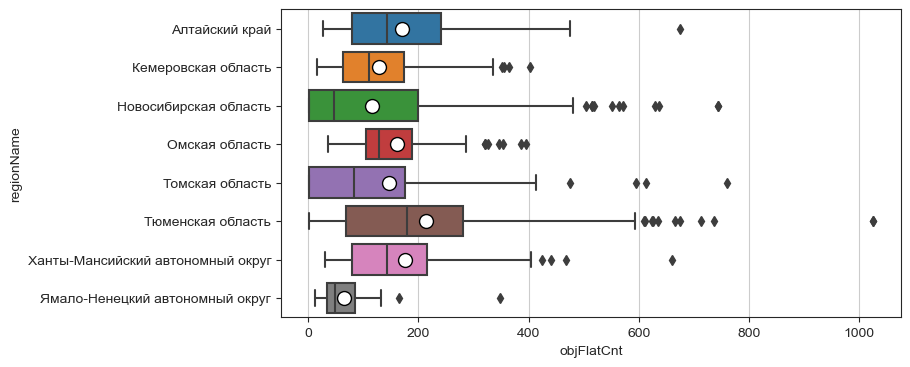

In [51]:
visualizer.make_boxplot('objFlatCnt')
visualizer.make_stats('objFlatCnt')

Выводы:
* разброс среднего кол-ва квартир в регионах небольшой (100-200 квартир)
* в Новосибирской области по медиане самое маленькое количество квартир в домах. С учетом выводов предыдущего графика можно сделать предположение, что строится много малоквартирных малоэтажных домов (видимо, элитное жилье)
* "человейники" на 500+ квартир строят во многих регионах
* в Тюменской области строятся самые большие "человейники" до 1000+ квартир

#### Жилая площадь в домах по регионам

,count,mean,std,min,25%,50%,75%,max
regionName,,,,,,,,
Алтайский край,69.0,8516.723623,6131.688576,1453.85,3382.400,6911.700,12278.600,33112.80
Кемеровская область,70.0,6582.649429,4208.390539,795.02,3411.375,6471.850,8415.250,19526.60
Новосибирская область,546.0,5773.463571,7150.994969,59.80,78.300,2260.590,9794.875,41405.95
Омская область,64.0,8275.589687,4541.106437,3133.52,4563.860,7033.750,10742.520,24888.40
Томская область,42.0,7712.105952,8662.999691,153.05,158.960,5173.340,8038.500,28328.00
Тюменская область,229.0,11031.920611,9484.671856,144.60,4121.300,9449.300,14856.490,53797.75
Ханты-Мансийский автономный округ,51.0,9819.836667,7966.818630,1824.20,3990.605,7534.200,12467.275,35777.47
Ямало-Ненецкий автономный округ,40.0,3215.173750,2747.381895,637.80,1716.225,2233.245,4587.980,16361.40


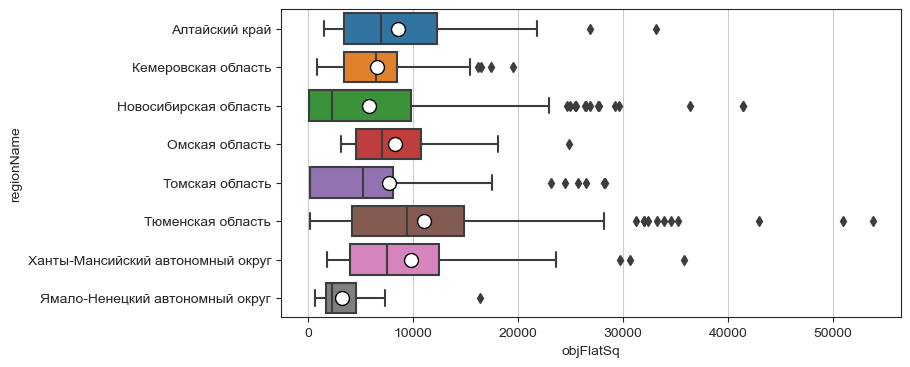

In [52]:
visualizer.make_boxplot('objFlatSq')
visualizer.make_stats('objFlatSq')

In [53]:
visualizer.living[['objFlatCnt', 'objFlatSq']].corr()

,objFlatCnt,objFlatSq
objFlatCnt,1.000000,0.963361
objFlatSq,0.963361,1.000000


Выводы:
* визуально видно, что диаграммы для площадей и количества квартир похожи
* коэффициент Пирсона говорит, что распределения площадей и количества квартир имеют сильную корреляцию

#### Количество парковочных мест в жилых домах по регионам

,count,mean,std,min,25%,50%,75%,max
regionName,,,,,,,,
Алтайский край,69.0,9.057971,27.695234,0.0,0.0,0.0,0.0,182.0
Кемеровская область,70.0,7.600000,24.072596,0.0,0.0,0.0,0.0,160.0
Новосибирская область,546.0,21.236264,59.770579,0.0,0.0,0.0,0.0,386.0
Омская область,64.0,9.078125,34.858583,0.0,0.0,0.0,0.0,227.0
Томская область,42.0,24.190476,49.931777,0.0,0.0,0.0,25.5,206.0
Тюменская область,229.0,30.633188,102.439567,0.0,0.0,0.0,0.0,704.0
Ханты-Мансийский автономный округ,51.0,34.960784,99.126578,0.0,0.0,0.0,0.0,440.0
Ямало-Ненецкий автономный округ,40.0,1.975000,9.099134,0.0,0.0,0.0,0.0,51.0


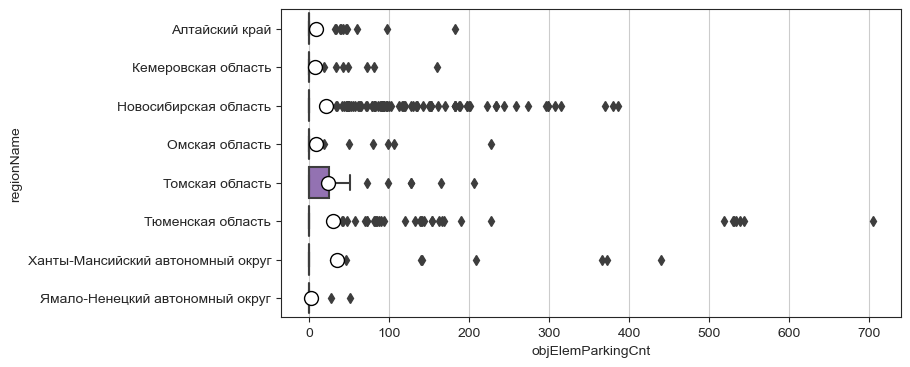

In [54]:
visualizer.make_boxplot('objElemParkingCnt')
visualizer.make_stats('objElemParkingCnt')

Выводы:
* основная масса жилых домов не имеет парковочных мест
* самое большое количество парковочных мест в доме из Тюменской области (в этом регионе самые большие "человейники")